# Load trained model parameters on new abstracts.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/elsevier/Bert-NER-V2'
%cd $path
import random
import utils_train as ut
import net
from transformers import BertForMaskedLM, BertTokenizer
import torch
!pip install highlight-text
import matplotlib.pyplot as plt
from highlight_text import HighlightText
import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/elsevier/Bert-NER-V2


## Load parameters

In [2]:
CLASSES = {'MATERIAL': 1, 'MLIP': 2, 'PROPERTY': 3,
           'VALUE': 4, 'APPLICATION': 5, 'O': 0}
# BATCH_SIZE = 1
SEED = 32
MAX_LENGTH = 512
ut.seed_everything(SEED)
modelBERT = BertForMaskedLM.from_pretrained('pranav-s/MaterialsBERT')
tokenizerBERT = BertTokenizer.from_pretrained('pranav-s/MaterialsBERT', model_max_length=MAX_LENGTH)
model = net.NERBERTModel(modelBERT.base_model, output_size=len(CLASSES)+1)
parameter_path = path + '/saved_models/test_model.pt'
model.load_state_dict(torch.load(parameter_path))
model.eval()
print('Model loaded')

Model loaded


## Feed text to model

In [3]:
example = 'High-entropy alloys (HEAs), characterized as compositionally complex solid solutions with five or more metal elements, have emerged as a novel class of catalytic materials with unique attributes. Because of the remarkable diversity of multielement sites or site ensembles stabilized by configurational entropy, human exploration of the multidimensional design space of HEAs presents a formidable challenge, necessitating an efficient, computational and data-driven strategy over traditional trial-and-error experimentation or physics-based modeling. Leveraging deep learning interatomic potentials for large-scale molecular simulations and pretrained machine learning models of surface reactivity, our approach effectively rationalizes the enhanced activity of a previously synthesized PdCuPtNiCo HEA nanoparticle system for electrochemical oxygen reduction, as corroborated by experimental observations. We contend that this framework deepens our fundamental understanding of the surface reactivity of high-entropy materials and fosters the accelerated development and synthesis of monodisperse HEA nanoparticles as a versatile material platform for catalyzing sustainable chemical and energy transformations.'
ex_list = ut.split_para(example)
token_list = tokenizerBERT.convert_tokens_to_ids(ex_list)
data_test = torch.tensor(token_list + [0] * (MAX_LENGTH - len(token_list)))[None, :]
att_mask_test = torch.tensor([1] * len(ex_list) + [0] * (MAX_LENGTH - len(ex_list)))[None, :]


In [4]:
y_pred_test = model(data_test, attention_mask=att_mask_test)
y_pred_test = torch.swapaxes(y_pred_test, 1, 2)
pred = y_pred_test.max(dim=1)[1][0][:len(ex_list)]

# Show prediction

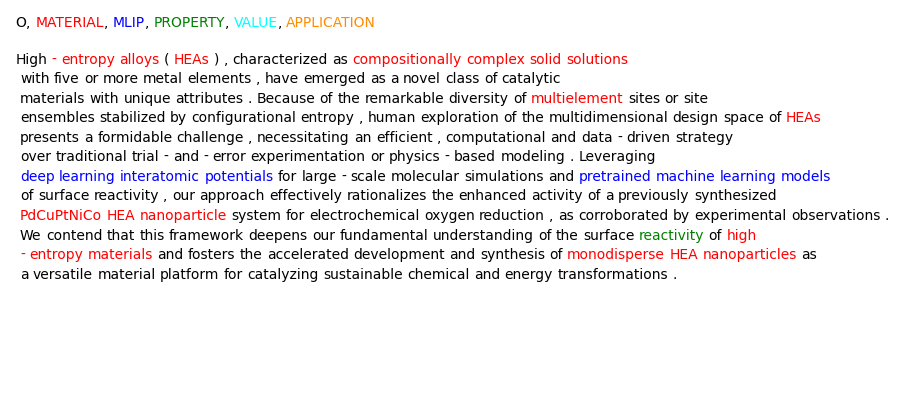

In [5]:
colors = ['black', 'red', 'blue', 'green', 'cyan', 'darkorange']
word_list_marked = ['<' + w + '>' for w in ex_list]
markers = [{"color": colors[i]} for i in pred]
j = 0
for i in range(len(ex_list)):
    if (i + 1) % 15 == 0:
        word_list_marked.insert(i + j, '\n')
        j += 1
fig, ax = plt.subplots()
ax.set_axis_off()
HighlightText(x=0., y=1, s='<O>, <MATERIAL>, <MLIP>, <PROPERTY>, <VALUE>, <APPLICATION>',
              highlight_textprops=[{"color": c} for c in colors], ax=ax)
HighlightText(x=0., y=0.9, s=' '.join(word_list_marked),
              highlight_textprops=markers, ax=ax)
plt.show()